# <font color='cornflowerblue'>Natural Language Inference Approach UM - Data Team Club

In the second UM Data Team Club project, we'll be diving into Natural Language Inference (NLI). Our goal is to explore and analyze the relationships between different text pairs to understand whether one sentence logically follows from another.

## Contents Table
 - [Imports](#1)
 - [Accelerator](#2)
 - [Load Data](#3)
 - [Data Exploring](#4)
 - [Data Preprocessing](#5)
 - [BERT Base Multi Model](#6)

In [11]:
# !pip install keras_nlp
# !pip install seaborn
# !pip install wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 520.1/520.1 kB 8.8 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


### Imports <a id='1'></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
sns.set_style('whitegrid')

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
import keras_nlp
import os

import warnings
warnings.filterwarnings('ignore')

D0908 22:36:40.044680303    1733 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D0908 22:36:40.044704793    1733 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D0908 22:36:40.044708321    1733 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D0908 22:36:40.044710917    1733 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D0908 22:36:40.044713353    1733 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D0908 22:36:40.044715659    1733 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D0908 22:36:40.044718058    1733 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D0908 22:36:40.

Using TensorFlow backend


### Accelerator <a id='2'></a>

In [2]:
 try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    print("TPU not activated")
    strategy = tf.distribute.MirroredStrategy()
    
print("replicas:", strategy.num_replicas_in_sync)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU

### Load Data <a id='3'></a>

In [4]:
df_train = pd.read_csv('/kaggle/input/contradictory-my-dear-watson/train.csv')
print(f"Train dataset size: {df_train.shape}")

Train dataset size: (12120, 6)


### Data Exploring <a id='4'></a>

In [5]:
df_train.head(3)

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0


The NLI model will assign labels of 0, 1, or 2 (corresponding to entailment, neutral, and contradiction) to pairs of premises and hypotheses.

| <span style="color:cornflowerblue">Label</span> | <span style="color:cornflowerblue">Description</span>       |
|---------------------------------------|---------------------------------------------------|
| 0                                     | Entailment                                        |
| 1                                     | Neutral                                           |
| 2                                     | Contradiction                                     |


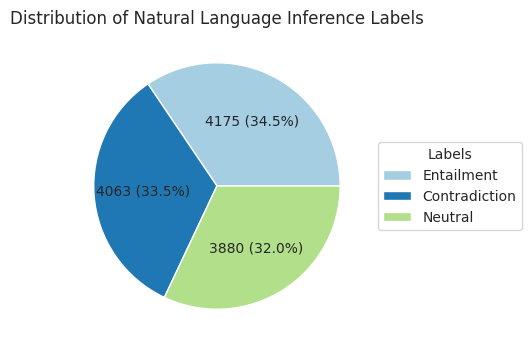

In [7]:
labels_map = {0: 'Entailment', 1: 'Neutral', 2: 'Contradiction'}
label_counts = df_train['label'].map(labels_map).value_counts()

def func(pct, allvals):
    absolute = int(pct/100.*sum(allvals))
    return f"{absolute} ({pct:.1f}%)"

plt.figure(figsize=(8, 4))
wedges, texts, autotexts = plt.pie(label_counts,autopct=lambda pct: func(pct, label_counts),labels=[None]*len(label_counts),colors=plt.cm.Paired.colors)
plt.legend(wedges, label_counts.index, title="Labels", loc="center left", bbox_to_anchor=(1, 0.5))
plt.title("Distribution of Natural Language Inference Labels")
display()

In [8]:
df_train['language'].value_counts()

language
English       6870
Chinese        411
Arabic         401
French         390
Swahili        385
Urdu           381
Vietnamese     379
Russian        376
Hindi          374
Greek          372
Thai           371
Spanish        366
Turkish        351
German         351
Bulgarian      342
Name: count, dtype: int64

In [9]:
train2 = df_train.copy()

def word_count(text):
    return len(text.split())

def char_count(text):
    return len(text)

train2['premise_word_count'] = train2['premise'].apply(word_count)
train2['premise_char_count'] = train2['premise'].apply(char_count)
train2['hypothesis_word_count'] = train2['hypothesis'].apply(word_count)
train2['hypothesis_char_count'] = train2['hypothesis'].apply(char_count)

def describe_column(column):
    stats = {
        'mean': int(column.mean()),
        'max': int(column.max()),
        'min': int(column.min())
    }
    return stats

premise_word_stats = describe_column(train2['premise_word_count'])
premise_char_stats = describe_column(train2['premise_char_count'])
hypothesis_word_stats = describe_column(train2['hypothesis_word_count'])
hypothesis_char_stats = describe_column(train2['hypothesis_char_count'])

stats = {
    'Premise Words': premise_word_stats,
    'Hypothesis Words': hypothesis_word_stats,
    'Premise Characters': premise_char_stats,
    'Hypothesis Characters': hypothesis_char_stats}

stats = pd.DataFrame(stats).T
stats

,mean,max,min
Premise Words,17,196,1
Hypothesis Words,9,46,1
Premise Characters,107,967,4
Hypothesis Characters,53,276,4


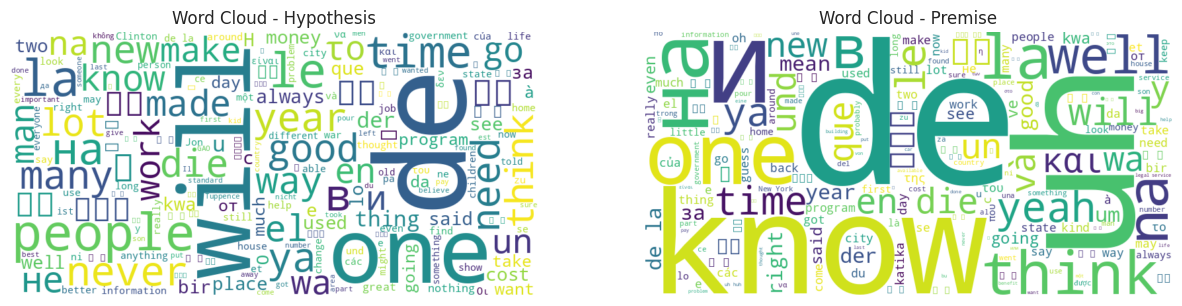

In [13]:
text_hypothesis = ' '.join(df_train['hypothesis'].astype(str))
wordcloud_hypothesis = WordCloud(width=800, height=400, background_color='white').generate(text_hypothesis)

text_premises = ' '.join(df_train['premise'].astype(str))
wordcloud_premises = WordCloud(width=800, height=400, background_color='white').generate(text_premises)

plt.figure(figsize=(15, 8))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_hypothesis, interpolation='bilinear')
plt.title('Word Cloud - Hypothesis')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_premises, interpolation='bilinear')
plt.title('Word Cloud - Premise')
plt.axis('off')

display()


### Data Preprocessing <a id='5'></a>

In [14]:
VALIDATION_SPLIT = 0.3
TRAIN_SIZE = int(df_train.shape[0]*(1-VALIDATION_SPLIT))
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

In [15]:
def split_labels(x, y):
    return (x[0], x[1]), y

training_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            df_train[['premise','hypothesis']].values,
            keras.utils.to_categorical(df_train['label'], num_classes=3)
        )
    )
)

train_dataset = training_dataset.take(TRAIN_SIZE)
val_dataset = training_dataset.skip(TRAIN_SIZE)

train_preprocessed = train_dataset.map(split_labels, tf.data.AUTOTUNE).batch(BATCH_SIZE, drop_remainder=True).cache().prefetch(tf.data.AUTOTUNE)
val_preprocessed = val_dataset.map(split_labels, tf.data.AUTOTUNE).batch(BATCH_SIZE, drop_remainder=True).cache().prefetch(tf.data.AUTOTUNE)

### BERT Base Multi <a id='6'></a>

In [16]:
with strategy.scope():
    classifier = keras_nlp.models.BertClassifier.from_preset("bert_base_multi", num_classes=3)
    classifier.compile(optimizer=keras.optimizers.Adam(1e-5*strategy.num_replicas_in_sync),
                       loss=keras.losses.CategoricalCrossentropy(from_logits=True),
                       metrics=['accuracy'])
    classifier.summary()

711647480/711647480 [==============================] - 5s 0us/step


Preprocessor: "bert_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ bert_tokenizer (BertTokenizer)                     │                                             119,547 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "bert_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                  ┃ Output Shape                           ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)                     │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ segment_ids (InputLayer)                      │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ token_ids (InputLayer)                        │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ bert_backbone (BertBackbone)                  │ {sequence_output: (None, None, 768),   │     177,853,440 │
│                                               │ pooled_output: (None, 768)}            │                 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ dropout (Dropout)                             │ (None, 768)                            │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ logits (Dense)                                │ (None, 3)                              │           2,307 │
└───────────────────────────────────────────────┴────────────────────────────────────────┴─────────────────┘

 Total params: 177,855,747 (678.47 MB)

 Trainable params: 177,855,747 (678.47 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
EPOCHS=7
history = classifier.fit(train_preprocessed,
                         epochs=EPOCHS,
                         validation_data=val_preprocessed)

Epoch 1/7


2024-09-08 22:54:53.503724: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2024-09-08 22:54:54.447557: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


66/66 [==============================] - ETA: 0s - loss: 0.9630 - accuracy: 0.5168

2024-09-08 22:56:17.093927: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2024-09-08 22:56:17.348394: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


66/66 [==============================] - 124s 659ms/step - loss: 0.9630 - accuracy: 0.5168 - val_loss: 0.8467 - val_accuracy: 0.6283
Epoch 2/7
66/66 [==============================] - 33s 490ms/step - loss: 0.7162 - accuracy: 0.6954 - val_loss: 0.8673 - val_accuracy: 0.6426
Epoch 3/7
66/66 [==============================] - 32s 492ms/step - loss: 0.5178 - accuracy: 0.7949 - val_loss: 1.0374 - val_accuracy: 0.5993
Epoch 4/7
66/66 [==============================] - 34s 516ms/step - loss: 0.3966 - accuracy: 0.8459 - val_loss: 1.1951 - val_accuracy: 0.6004
Epoch 5/7
66/66 [==============================] - 33s 495ms/step - loss: 0.2504 - accuracy: 0.9077 - val_loss: 1.3536 - val_accuracy: 0.6258
Epoch 6/7
66/66 [==============================] - 33s 495ms/step - loss: 0.1890 - accuracy: 0.9341 - val_loss: 1.3695 - val_accuracy: 0.6328
Epoch 7/7
66/66 [==============================] - 33s 495ms/step - loss: 0.1651 - accuracy: 0.9392 - val_loss: 1.4446 - val_accuracy: 0.6208


In [37]:
history_df = pd.DataFrame(history.history)
history_df.index = range(1, len(history_df) + 1)

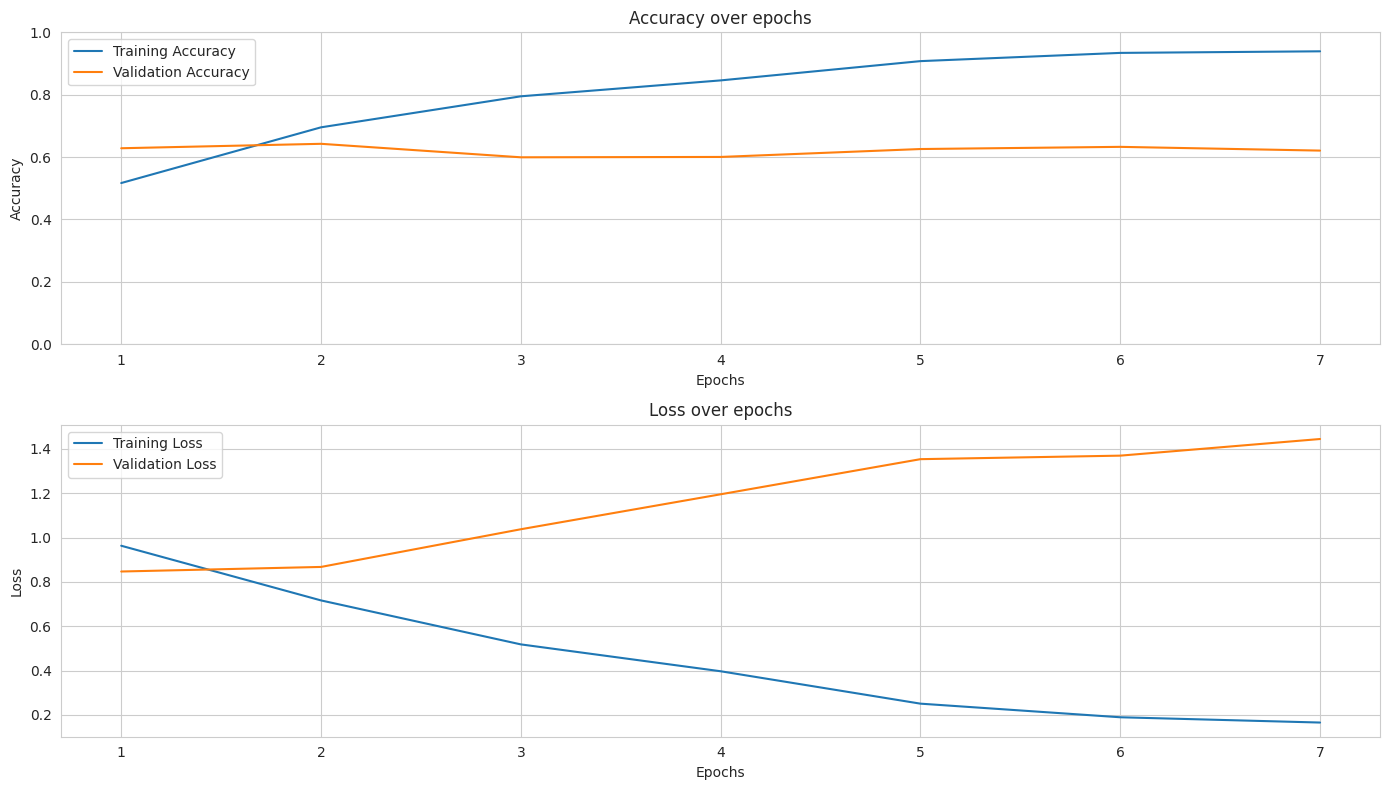

In [39]:
plt.figure(figsize=(14, 8))

plt.subplot(2, 1, 1)
plt.plot(history_df['accuracy'], label='Training Accuracy')
plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(history_df['loss'], label='Training Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
display()